# Example of using the `Streetscape` class

The usage on the French data from Alessandro.

In [1]:
import geopandas as gpd
import momepy
import pandas as pd
import rioxarray

/Users/martin/dev/uscuni/streetscape/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read all the data. Only streets and buildings are required.

In [2]:
streets = gpd.read_file("data/input/streets.gpkg")
buildings = gpd.read_file("data/input/buildings.gpkg")
plots = gpd.read_file("data/input/plots.gpkg")
dtm = rioxarray.open_rasterio("data/input/dtm_5m.tiff")

Check the size of the input data. Ensure that all use the same CRS.

In [3]:
streets.shape, buildings.shape, plots.shape, dtm.shape

((13562, 17), (80385, 29), (69163, 9), (1, 3000, 4000))

The building category is required to be encoded as integers.

In [4]:
labels, names = pd.factorize(buildings["USAGE1"])
buildings["category"] = labels

Initiate the class. This will dricectly compute builk of the sightline indicators based on streets and buildings.

In [5]:
%%time
sc = momepy.Streetscape(streets, buildings, category_col="category", height_col="HAUTEUR")

CPU times: user 12min 15s, sys: 2.09 s, total: 12min 18s
Wall time: 12min 21s


If you have plots and DTM, you can use two additional methods to compute additional variables.

In [6]:
%%time
sc.compute_plots(plots)


CPU times: user 5min 19s, sys: 718 ms, total: 5min 20s
Wall time: 5min 21s


In [7]:
%%time
sc.compute_slope(dtm)

CPU times: user 56.3 s, sys: 1.48 s, total: 57.8 s
Wall time: 57.9 s


The resulting data can be extracted either on a street level:

In [ ]:
%%time
street_df = sc.street_level()

street_df.to_parquet('data/output/street_level.parquet')
street_df.head()

CPU times: user 1min 30s, sys: 421 ms, total: 1min 30s
Wall time: 1min 32s


,N,n_l,n_r,left_os,right_os,os,left_os_std,right_os_std,os_std,left_os_mad,...,plot_WP_ratio,left_plot_WP_ratio,right_plot_WP_ratio,left_plot_seq_sb_index,right_plot_seq_sb_index,slope_degree,slope_percent,n_slopes,slope_valid,geometry
street_index,,,,,,,,,,,,,,,,,,,,,
0,19,17,17,17.015532,17.782123,34.797654,11.629486,11.408623,11.362847,6.944099,...,0.030409,0.028790,0.032028,{29684},{29686},0.731112,0.012762,19,True,"LINESTRING (1045485 6299352.4, 1045487.5 62993..."
1,7,7,5,30.049410,22.433788,52.483198,10.785169,18.861793,14.760974,9.341865,...,0.011164,0.011800,0.010607,{29686},{29684},0.455361,0.007949,7,True,"LINESTRING (1045485 6299352.4, 1045479.8 62993..."
2,7,4,0,48.489445,50.000000,98.489445,1.878186,0.000000,1.275976,1.694906,...,0.028957,0.005581,0.063703,"{31244, 29685, 29686}","{29638, 29641, 29642, 29684, 29685}",0.981039,0.017127,7,True,"LINESTRING (1045479 6299331.5, 1045477.2 62993..."
3,11,8,10,23.601719,18.577099,42.178818,16.955487,14.452640,15.374180,14.399062,...,0.016373,0.015319,0.009713,"{29681, 29684}","{29684, 29686}",0.313481,0.005471,11,True,"LINESTRING (1045490.6 6299407.5, 1045491.8 629..."
4,10,7,8,25.806848,18.519860,44.326708,16.723757,16.629805,16.232051,14.515891,...,0.014357,0.012727,0.009624,"{29681, 29684}","{29684, 29686}",0.645537,0.011268,10,True,"LINESTRING (1045491.8 6299440.2, 1045494.5 629..."


It is a GeoDataFrame, so you can directly plot it.

<Axes: >

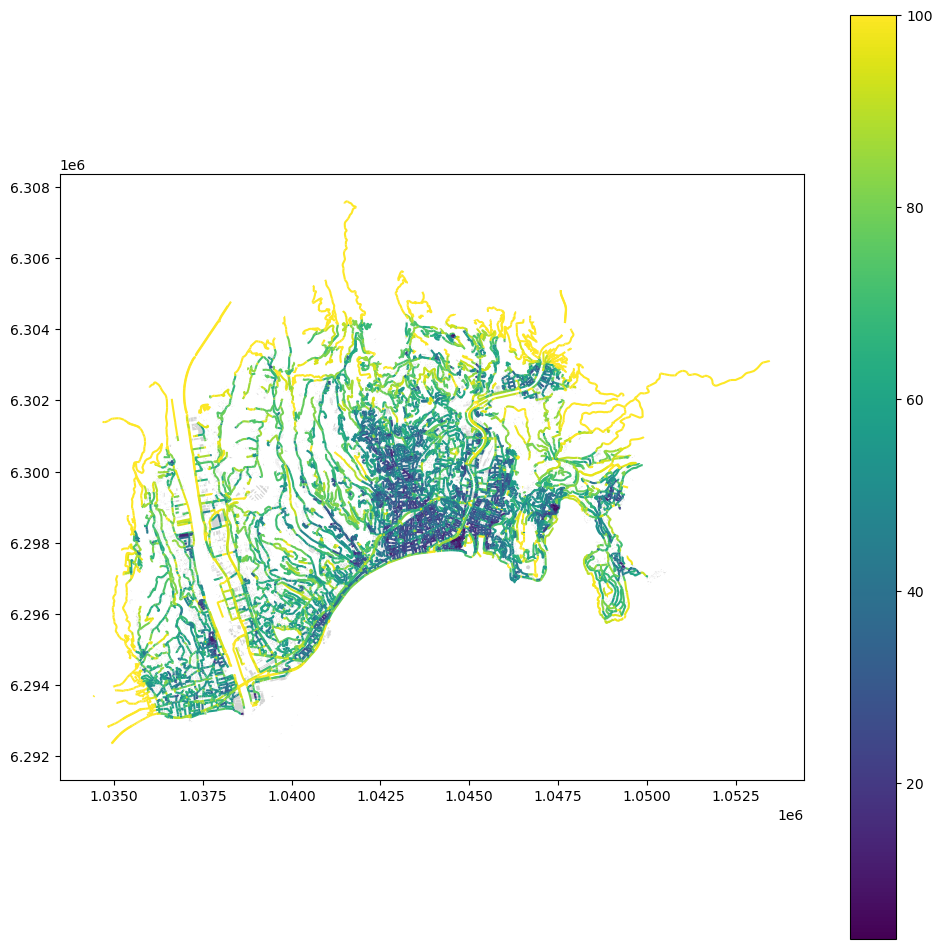

In [9]:
ax = street_df.plot("os", figsize=(12, 12), legend=True)
buildings.plot(ax=ax, color="lightgray")

Or for all individual sightline points.

In [ ]:
point_df = sc.point_level()

point_df.to_parquet('data/output/point_level.parquet')
point_df.head()

,geometry,left_os_count,left_os,left_sb_count,left_sb,left_h,left_hw,left_bc,right_os_count,right_os,...,right_plot_seq_sb_index,os_count,os,sb_count,sb,h,hw,bc,plot_seq_sb,plot_seq_sb_depth
street_index,,,,,,,,,,,,,,,,,,,,,
0,POINT (1045485.039 6299352.899),1.0,12.820973,1.0,12.820973,26.8,2.090325,24.978529,1.0,15.463321,...,{29686},2.0,14.142147,2.0,14.142147,22.95,1.662753,24.847670,6.629924,22.081444
0,POINT (1045485.27 6299355.913),1.0,12.836108,1.0,12.836108,26.8,2.087860,28.931986,1.0,15.399049,...,{29686},2.0,14.117578,2.0,14.117578,22.95,1.664098,27.038365,7.344145,21.365515
0,POINT (1045485.502 6299358.926),1.0,12.851243,1.0,12.851243,26.8,2.085401,32.885444,1.0,15.334777,...,{29686},2.0,14.093010,2.0,14.093010,22.95,1.665468,29.229060,7.296184,21.411735
0,POINT (1045485.734 6299361.94),1.0,12.866378,1.0,12.866378,26.8,2.082948,36.838901,1.0,15.270505,...,{29686},2.0,14.068441,2.0,14.068441,22.95,1.666863,31.419755,7.248223,21.457954
0,POINT (1045485.966 6299364.954),1.0,12.881513,1.0,12.881513,26.8,2.080501,37.118487,1.0,15.206233,...,{29686},2.0,14.043873,2.0,14.043873,22.95,1.668282,24.518223,7.200263,21.504174


Again, it is a GeoDataFrame, this time with point geometry.

<Axes: >

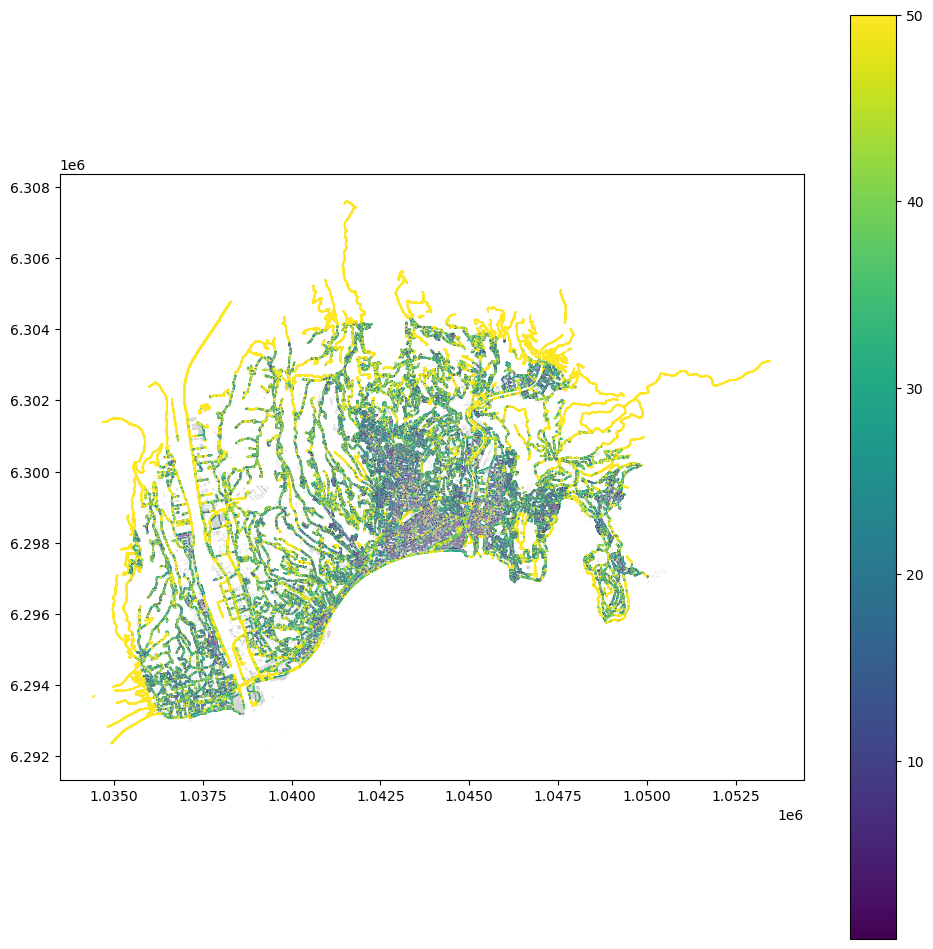

In [11]:
ax = point_df.plot("os", figsize=(12, 12), legend=True, markersize=.1)
buildings.plot(ax=ax, color="lightgray")